In [8]:
#необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Загрузка данных
df = pd.read_csv('S02-hw-dataset.csv')

# Вывод первых строк
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [3]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


In [4]:
# Доля пропусков по столбцам
missing = df.isna().mean()
missing

,0
user_id,0.00000
age,0.04878
country,0.00000
purchases,0.00000
revenue,0.00000


In [5]:
# Проверка на дубликаты
duplicates = df.duplicated().sum()
print(f"Количество полностью дублирующих строк: {duplicates}")

Количество полностью дублирующих строк: 1


In [6]:
# Подозрительные значения
suspicious = df[
    (df['age'] < 0) | (df['age'] > 120) |
    (df['purchases'] < 0) |
    (df['revenue'] < 0) |
    ((df['purchases'] <= 0) & (df['revenue'] > 0)) |
    ((df['purchases'] > 0) & (df['revenue'] == 0))
].dropna(how='all')

if not suspicious.empty:
    print("Найдены подозрительные строки:")
    display(suspicious)
else:
    print("Подозрительных значений нет.")

Найдены подозрительные строки:


,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
10,11,24.0,US,4,0


В данных обнаружены: отрицательное количество покупок (`purchases = -1`) и нулевая выручка при 4 покупках — такие значения нелогичны. Также есть пользователь с возрастом 120 лет, что маловероятно и может искажать анализ. Эти ошибки требуют очистки данных перед дальнейшей работой.

In [7]:
# 1. Частоты категориальной переменной: распределение по странам
print("Распределение пользователей по странам:")
display(df['country'].value_counts())

# 2. Группировка по стране: средняя выручка, общее число покупок
print("\nАгрегаты по странам:")
eda_grouped = df.groupby('country').agg(
    avg_revenue=('revenue', 'mean'),
    total_purchases=('purchases', 'sum'),
    avg_age=('age', 'mean'),
    users=('user_id', 'count')
).round(2)
display(eda_grouped)

# 3. Возрастные группы
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 50, 100],
                        labels=['<18', '18-30', '31-50', '50+'])

print("\nСредняя выручка по возрастным группам:")
display(df.groupby('age_group')['revenue'].mean().round(2))

Распределение пользователей по странам:


,count
country,
RU,13
FR,12
US,8
DE,6
CN,2



Агрегаты по странам:


,avg_revenue,total_purchases,avg_age,users
country,,,,
CN,1054.00,9,24.00,2
DE,1445.50,39,34.60,6
FR,675.92,51,46.25,12
RU,790.08,62,30.08,13
US,557.38,37,36.71,8



Средняя выручка по возрастным группам:


/tmp/ipython-input-3242039704.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('age_group')['revenue'].mean().round(2))


,revenue
age_group,
<18,1296.00
18-30,565.54
31-50,1022.76
50+,596.67


Больше всего пользователей из России и Франции, но больше всего денег тратят клиенты из Германии и Китая. США — много пользователей, но низкие траты.

Самая высокая средняя выручка — у подростков до 18 лет, что выглядит странно и, скорее всего, связано с малым числом таких пользователей или ошибкой в данных.

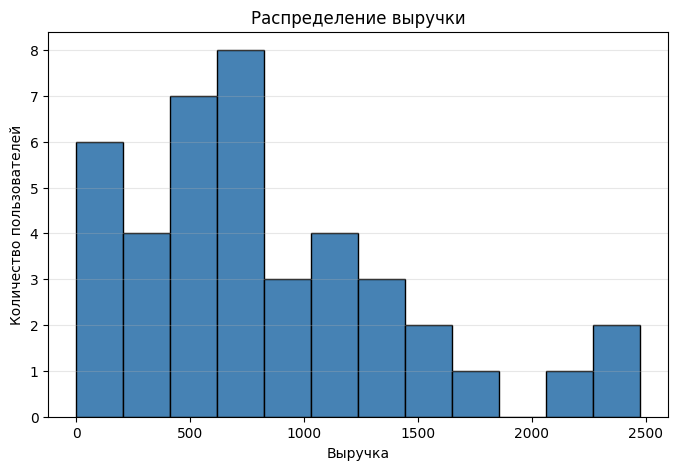

In [9]:
os.makedirs('figures', exist_ok=True)

# Гистограмма — распределение выручки
plt.figure(figsize=(8, 5))
plt.hist(df['revenue'], bins=12, color='steelblue', edgecolor='black')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', alpha=0.3)
plt.savefig('figures/revenue_histogram.png')
plt.show()

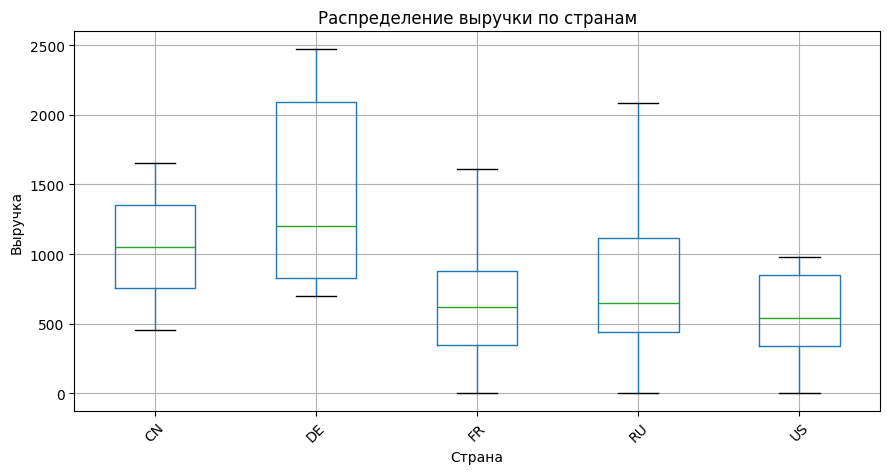

In [10]:
plt.figure(figsize=(9, 5))
df.boxplot(column='revenue', by='country', ax=plt.gca())
plt.title('Распределение выручки по странам')
plt.suptitle('')
plt.xlabel('Страна')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/revenue_boxplot_by_country.png')
plt.show()

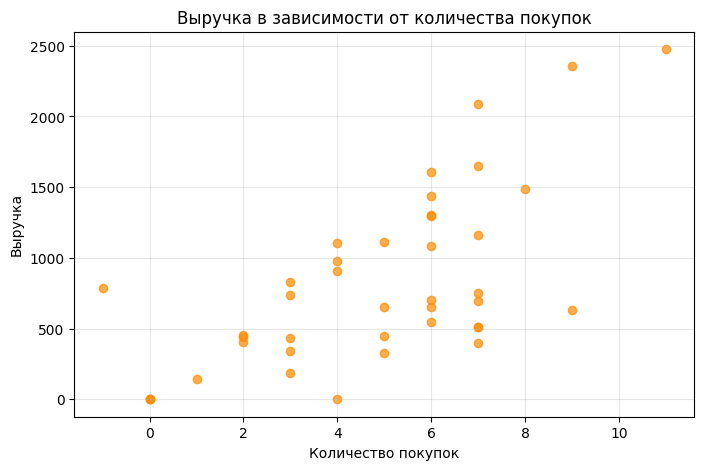

In [11]:
#  Scatter plot — связь между покупками и выручкой
plt.figure(figsize=(8, 5))
scatter = plt.scatter(df['purchases'], df['revenue'], c='darkorange', alpha=0.7)
plt.title('Выручка в зависимости от количества покупок')
plt.xlabel('Количество покупок')
plt.ylabel('Выручка')
plt.grid(True, alpha=0.3)
plt.savefig('figures/purchases_vs_revenue_scatter.png')
plt.show()